In [3]:
import tensorflow as tf
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable
import pandas as pd
import math
import sklearn.preprocessing as sk
from tensorboardX import SummaryWriter
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
import random

seed = 42
random.seed(seed)

N = 10000
M = 100
c = 0.5
p = 0.9
k = np.random.randn(M)
u1 = np.random.randn(M)
u1 -= u1.dot(k) * k / np.linalg.norm(k)**2
u1 /= np.linalg.norm(u1) 
k /= np.linalg.norm(k) 
u2 = k
w1 = c*u1
w2 = c*(p*u1+np.sqrt((1-p**2))*u2)
X = np.random.normal(0, 1, (N, M))
eps1 = np.random.normal(0, 0.01)
eps2 = np.random.normal(0, 0.01)
Y1 = np.matmul(X, w1) + np.sin(np.matmul(X, w1))+eps1
Y2 = np.matmul(X, w2) + np.sin(np.matmul(X, w2))+eps2
split = list(np.random.permutation(N))

X_train = X[split[0:8000],:]
Y1_train = Y1[split[0:8000]].reshape(-1,1)
Y2_train = Y2[split[0:8000]].reshape(-1,1)
X_valid = X[8000:9000,:]
Y1_valid = Y1[8000:9000].reshape(-1,1)
Y2_valid = Y2[8000:9000].reshape(-1,1)
X_test = X[9000:10000,:]
Y1_test = Y1[9000:10000].reshape(-1,1)
Y2_test = Y2[9000:10000].reshape(-1,1)
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
print(Y1_train.shape)
print(Y2_train.shape)
print(Y1_valid.shape)
print(Y2_valid.shape)
print(Y1_test.shape)
print(Y2_test.shape)
Y_train = np.concatenate((Y1_train.reshape(-1,1), Y2_train.reshape(-1,1)), axis=1)
Y_valid = np.concatenate((Y1_valid.reshape(-1,1), Y2_valid.reshape(-1,1)), axis=1)
Y_test = np.concatenate((Y1_test.reshape(-1,1), Y2_test.reshape(-1,1)), axis=1)
print(Y_train.shape)
print(Y_valid.shape)
print(Y_test.shape)

(8000, 100)
(1000, 100)
(1000, 100)
(8000, 1)
(8000, 1)
(1000, 1)
(1000, 1)
(1000, 1)
(1000, 1)
(8000, 2)
(1000, 2)
(1000, 2)


Epoch: 0, Train Cost: 1.284 
Epoch: 0, Dev Cost: 0.959 
Epoch: 1, Train Cost: 0.888 
Epoch: 1, Dev Cost: 0.822 
Epoch: 2, Train Cost: 0.743 
Epoch: 2, Dev Cost: 0.665 
Epoch: 3, Train Cost: 0.600 
Epoch: 3, Dev Cost: 0.523 
Epoch: 4, Train Cost: 0.470 
Epoch: 4, Dev Cost: 0.414 
Epoch: 5, Train Cost: 0.391 
Epoch: 5, Dev Cost: 0.359 
Epoch: 6, Train Cost: 0.334 
Epoch: 6, Dev Cost: 0.319 
Epoch: 7, Train Cost: 0.296 
Epoch: 7, Dev Cost: 0.282 
Epoch: 8, Train Cost: 0.267 
Epoch: 8, Dev Cost: 0.253 
Epoch: 9, Train Cost: 0.247 
Epoch: 9, Dev Cost: 0.240 
Epoch: 10, Train Cost: 0.228 
Epoch: 10, Dev Cost: 0.237 
Epoch: 11, Train Cost: 0.217 
Epoch: 11, Dev Cost: 0.218 
Epoch: 12, Train Cost: 0.204 
Epoch: 12, Dev Cost: 0.193 
Epoch: 13, Train Cost: 0.195 
Epoch: 13, Dev Cost: 0.178 
Epoch: 14, Train Cost: 0.185 
Epoch: 14, Dev Cost: 0.185 
Epoch: 15, Train Cost: 0.178 
Epoch: 15, Dev Cost: 0.178 
Epoch: 16, Train Cost: 0.172 
Epoch: 16, Dev Cost: 0.161 
Epoch: 17, Train Cost: 0.166 
Epoc

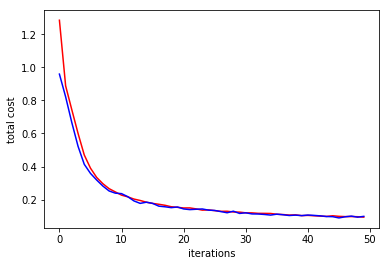

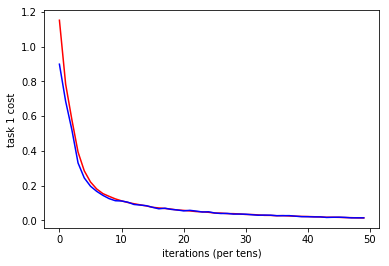

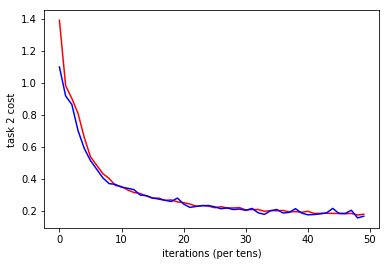

In [4]:
learning_rate = 0.001
mb_size = 100
n_shared = 64
n_hidden1 = 32
n_hidden2 = 16
num_epochs = 50
#keep_prob = 1
n_output = 1

def PlaceHolder(dims):
    PH = tf.placeholder("float", [None, dims])
    return PH 

def Shared_layer(dat, keep_prob):

    H1 = tf.layers.dense(inputs=dat, units=n_shared, activation=tf.nn.relu)
    Drop_H1 = tf.nn.dropout(H1, keep_prob)
    #bn_Drop_H1 = tf.contrib.layers.batch_norm(Drop_H1, center =True, scale = True)    

    return Drop_H1

def Tower_layer1(dat, keep_prob):

    H1 = tf.layers.dense(inputs=dat, units=n_hidden1, activation=tf.nn.relu)
    Drop_H1 = tf.layers.dropout(H1, keep_prob)
    #bn_Drop_H1 = tf.contrib.layers.batch_norm(Drop_H1, center =True, scale = True)

    H2 = tf.layers.dense(inputs=Drop_H1, units=n_hidden2, activation=tf.nn.relu)
    Drop_H2 = tf.layers.dropout(H2, keep_prob)
    #bn_Drop_H2 = tf.contrib.layers.batch_norm(Drop_H2, center =True, scale = True)

    H3 = tf.layers.dense(inputs=Drop_H2, units=n_output)

    return H3

def Tower_layer2(dat, keep_prob):

    H1 = tf.layers.dense(inputs=dat, units=n_hidden1, activation=tf.nn.relu)
    Drop_H1 = tf.nn.dropout(H1, keep_prob)
    #bn_Drop_H1 = tf.contrib.layers.batch_norm(Drop_H1, center =True, scale = True)

    H2 = tf.layers.dense(inputs=Drop_H1, units=n_hidden2, activation=tf.nn.relu)
    Drop_H2 = tf.nn.dropout(H2, keep_prob)
    #bn_Drop_H2 = tf.contrib.layers.batch_norm(Drop_H2, center =True, scale = True)

    H3 = tf.layers.dense(inputs=Drop_H2, units=n_output)

    return H3

def compute_cost(Y_pred, Y_true):

    Logits = Y_pred
    Labels = Y_true 
    #Labels = tf.reshape(Labels, [-1,1])
    Loss = tf.losses.mean_squared_error(Labels, Logits)
    cost = tf.reduce_mean(Loss)       
    return cost

def random_mini_batches(XE, R1E, R2E, mini_batch_size = 10, seed = 42): 
    # Creating the mini-batches
    np.random.seed(seed)            
    m = XE.shape[0]                  
    mini_batches = []
    permutation = list(np.random.permutation(m))
    shuffled_XE = XE[permutation,:]
    shuffled_X1R = R1E[permutation]
    shuffled_X2R = R2E[permutation]
    num_complete_minibatches = math.floor(m/mini_batch_size)
    for k in range(0, int(num_complete_minibatches)):
        mini_batch_XE = shuffled_XE[k * mini_batch_size : (k+1) * mini_batch_size, :]
        mini_batch_X1R = shuffled_X1R[k * mini_batch_size : (k+1) * mini_batch_size]
        mini_batch_X2R = shuffled_X2R[k * mini_batch_size : (k+1) * mini_batch_size]
        mini_batch = (mini_batch_XE, mini_batch_X1R, mini_batch_X2R)
        mini_batches.append(mini_batch)
    Lower = int(num_complete_minibatches * mini_batch_size)
    Upper = int(m - (mini_batch_size * math.floor(m/mini_batch_size)))
    if m % mini_batch_size != 0:
        mini_batch_XE = shuffled_XE[Lower : Lower + Upper, :]
        mini_batch_X1R = shuffled_X1R[Lower : Lower + Upper]
        mini_batch_X2R = shuffled_X2R[Lower : Lower + Upper]
        mini_batch = (mini_batch_XE, mini_batch_X1R, mini_batch_X2R)
        mini_batches.append(mini_batch)
    
    return mini_batches

seed = 42 
tf.set_random_seed(seed)    
(n_samp, n_gene) = X_train.shape
(n_samp, n_out) = Y_train.shape
n_task = 1
cost1tr = []
cost2tr = []
cost1D = []
cost2D = []
cost1ts = []
cost2ts = []
costtr = []
costD = []
costts = []

tf.reset_default_graph()

X = PlaceHolder(n_gene)
Y1 = PlaceHolder(n_task)
Y2 = PlaceHolder(n_task)
kp = tf.placeholder(tf.float32)

H_shared = Shared_layer(X, kp)
H1 = Tower_layer1(H_shared, kp)
H2 = Tower_layer2(H_shared, kp)
        
cost1 = compute_cost(H1, Y1)
cost2 = compute_cost(H2, Y2)

cost = (cost1 + cost2)/2

optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
init = tf.global_variables_initializer()

with tf.Session() as sess:       
    sess.run(init)
    for epoch in range(num_epochs):
        epoch_cost = 0  
        epoch_cost1 = 0
        epoch_cost2 = 0
        
        num_minibatches = int(n_samp / mb_size) 
        minibatches = random_mini_batches(X_train, Y1_train, Y2_train, mb_size, seed)

        for minibatch in minibatches:
            (mb_X, mb_Y1, mb_Y2) = minibatch
            _ , minibatch_cost= sess.run([optimizer, cost], feed_dict={X: mb_X, Y1: mb_Y1, Y2: mb_Y2, kp: 0.5})
            epoch_cost = epoch_cost + (minibatch_cost / num_minibatches)
            
            mb_cost1 = sess.run(cost1, feed_dict={X: mb_X, Y1: mb_Y1, Y2: mb_Y2, kp: 0.5})
            epoch_cost1 = epoch_cost1 + (mb_cost1 / num_minibatches)
            
            mb_cost2 = sess.run(cost2, feed_dict={X: mb_X, Y1: mb_Y1, Y2: mb_Y2, kp: 0.5})
            epoch_cost2 = epoch_cost2 + (mb_cost2 / num_minibatches)
            
        if epoch % 1 == 0:
            print('Epoch: %d, Train Cost: %5.3f ' % (epoch, epoch_cost))
            dv_cost = sess.run(cost, feed_dict={X:X_valid, Y1: Y1_valid, Y2: Y2_valid, kp: 0.5})
            cost1D.append(sess.run(cost1, feed_dict={X:X_valid, Y1: Y1_valid, Y2: Y2_valid, kp: 0.5}))
            cost2D.append(sess.run(cost2, feed_dict={X:X_valid, Y1: Y1_valid, Y2: Y2_valid, kp: 0.5}))

            print('Epoch: %d, Dev Cost: %5.3f ' % (epoch, dv_cost))
        costtr.append(np.mean(epoch_cost))
        cost1tr.append(np.mean(epoch_cost1))
        cost2tr.append(np.mean(epoch_cost2))
        costD.append(dv_cost)

plt.plot(np.squeeze(costtr),'-r',np.squeeze(costD), '-b')
plt.ylabel('total cost')
plt.xlabel('iterations')
plt.show()

plt.plot(np.squeeze(cost1tr), '-r', np.squeeze(cost1D), '-b')
plt.ylabel('task 1 cost')
plt.xlabel('iterations (per tens)')
plt.show() 

plt.plot(np.squeeze(cost2tr),'-r', np.squeeze(cost2D),'-b')
plt.ylabel('task 2 cost')
plt.xlabel('iterations (per tens)')
plt.show()
